In [2]:
import pandas as pd
import numpy as np
from pathlib import Path


In [3]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
links = pd.read_csv('links.csv')

print("Movies:")
display(movies.head())
print("\nRatings:")
display(ratings.head())
print("\nLinks:")
display(links.head())

Movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



Ratings:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931



Links:


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [4]:
# %%
# CELL 3: Clean Movie Titles and Genres
movies['title'] = movies['title'].fillna('').str.strip().str.lower()
movies['genres'] = movies['genres'].fillna('(no genres listed)')
movies['genres_list'] = movies['genres'].str.split('|')
movies['genres_list'] = movies['genres_list'].apply(
    lambda lst: [g.strip().lower().replace('-', ' ') for g in lst] if isinstance(lst, list) else []
)
movies['genres_text'] = movies['genres_list'].apply(lambda lst: ' '.join(sorted(set(lst))))

display(movies[['movieId', 'title', 'genres_text']].head())


,movieId,title,genres_text
0,1,toy story (1995),adventure animation children comedy fantasy
1,2,jumanji (1995),adventure children fantasy
2,3,grumpier old men (1995),comedy romance
3,4,waiting to exhale (1995),comedy drama romance
4,5,father of the bride part ii (1995),comedy


In [ ]:

ratings = ratings.dropna(subset=['movieId', 'rating'])
agg = ratings.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    rating_count=('rating', 'size')
).reset_index()

if not agg.empty:
    min_r, max_r = agg['avg_rating'].min(), agg['avg_rating'].max()
    agg['norm_rating'] = (agg['avg_rating'] - min_r) / (max_r - min_r) if max_r > min_r else 0.5
else:
    agg['norm_rating'] = pd.Series(dtype=float)


display(agg.head())


,movieId,avg_rating,rating_count,norm_rating
0,1,3.920930,215,0.760207
1,2,3.431818,110,0.651515
2,3,3.259615,52,0.613248
3,4,2.357143,7,0.412698
4,5,3.071429,49,0.571429


In [6]:

df = movies.merge(links[['movieId', 'tmdbId']], on='movieId', how='left')
df = df.merge(agg, on='movieId', how='left')

df['avg_rating'] = df['avg_rating'].fillna(0.0)
df['norm_rating'] = df['norm_rating'].fillna(0.0)
df['rating_count'] = df['rating_count'].fillna(0).astype(int)

def to_int_or_none(x):
    try:
        xi = int(x)
        return xi if xi > 0 else np.nan
    except Exception:
        return np.nan

df['tmdbId'] = df['tmdbId'].apply(to_int_or_none)

out_cols = ['movieId', 'tmdbId', 'title', 'genres_text', 'avg_rating', 'norm_rating', 'rating_count']
cleaned = df[out_cols].copy()
cleaned.to_csv('cleaned_movies.csv', index=False)


display(cleaned.head(10))


,movieId,tmdbId,title,genres_text,avg_rating,norm_rating,rating_count
0,1,862.0,toy story (1995),adventure animation children comedy fantasy,3.920930,0.760207,215
1,2,8844.0,jumanji (1995),adventure children fantasy,3.431818,0.651515,110
2,3,15602.0,grumpier old men (1995),comedy romance,3.259615,0.613248,52
3,4,31357.0,waiting to exhale (1995),comedy drama romance,2.357143,0.412698,7
4,5,11862.0,father of the bride part ii (1995),comedy,3.071429,0.571429,49
5,6,949.0,heat (1995),action crime thriller,3.946078,0.765795,102
6,7,11860.0,sabrina (1995),comedy romance,3.185185,0.596708,54
7,8,45325.0,tom and huck (1995),adventure children,2.875000,0.527778,8
8,9,9091.0,sudden death (1995),action,3.125000,0.583333,16
9,10,710.0,goldeneye (1995),action adventure thriller,3.496212,0.665825,132


/var/folders/w5/5tztv4pd2tbbgtvr7q2sjflr0000gn/T/ipykernel_1530/1236688717.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, ax=ax, palette='Blues_r')


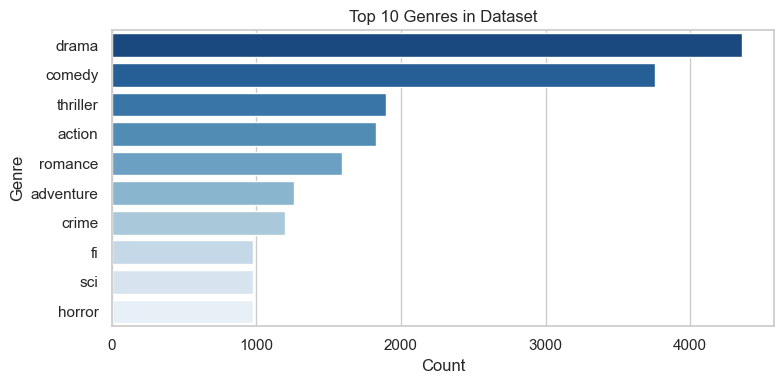

✅ Genre distribution plotted


In [7]:

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')

genres_flat = []
for g in cleaned['genres_text'].fillna(''):
    genres_flat += str(g).split()

if genres_flat:
    genre_counts = pd.Series(genres_flat).value_counts().head(10)
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.barplot(x=genre_counts.values, y=genre_counts.index, ax=ax, palette='Blues_r')
    ax.set_title('Top 10 Genres in Dataset')
    ax.set_xlabel('Count')
    ax.set_ylabel('Genre')
    plt.tight_layout()
    plt.show()

print("✅ Genre distribution plotted")


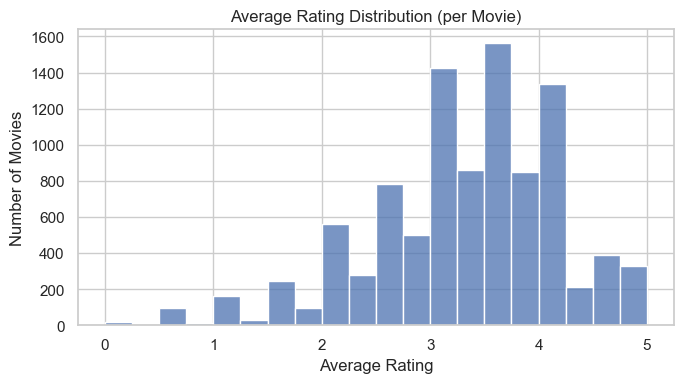

✅ Rating distribution plotted


In [8]:

fig2, ax2 = plt.subplots(figsize=(7, 4))
sns.histplot(cleaned['avg_rating'], bins=20, kde=False, ax=ax2, color='#4c72b0')
ax2.set_title('Average Rating Distribution (per Movie)')
ax2.set_xlabel('Average Rating')
ax2.set_ylabel('Number of Movies')
plt.tight_layout()
plt.show()

print("✅ Rating distribution plotted")


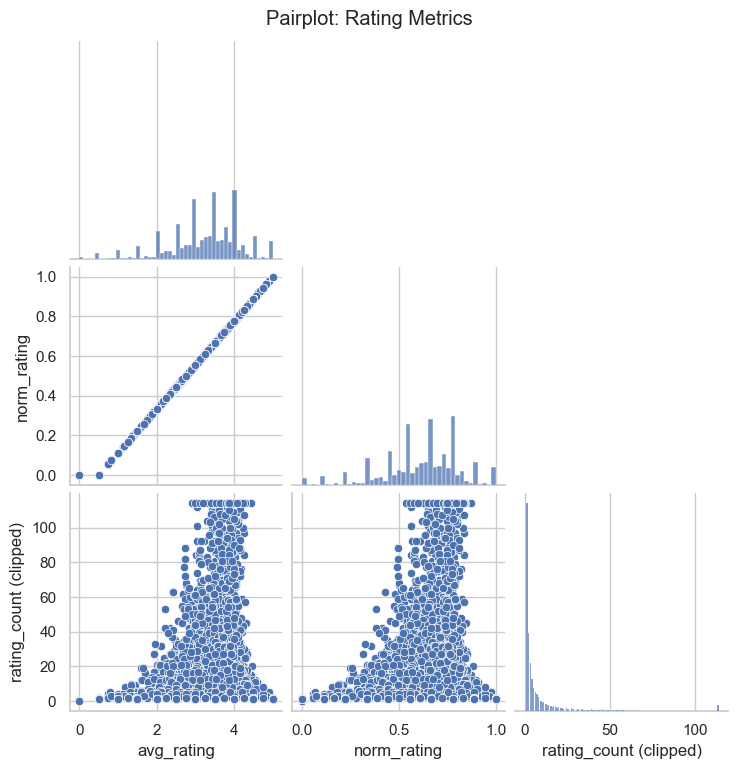

✅ Pairplot created


In [9]:

pair_cols = ['avg_rating', 'norm_rating', 'rating_count']
subset = cleaned[pair_cols].copy()
subset['rating_count_clipped'] = subset['rating_count'].clip(upper=subset['rating_count'].quantile(0.99))

sns.pairplot(
    subset.rename(columns={'rating_count_clipped': 'rating_count (clipped)'}),
    vars=['avg_rating', 'norm_rating', 'rating_count (clipped)'],
    diag_kind='hist',
    corner=True
)
plt.suptitle('Pairplot: Rating Metrics', y=1.02)
plt.show()

print("✅ Pairplot created")


In [10]:

from sklearn.model_selection import train_test_split

ratings_train, ratings_test = train_test_split(ratings, test_size=0.2, random_state=42)
TRAIN_CSV ='ratings_train.csv'
TEST_CSV =  'ratings_test.csv'

ratings_train.to_csv(TRAIN_CSV, index=False)
ratings_test.to_csv(TEST_CSV, index=False)

print(f"✅ Train set: {len(ratings_train)} ratings")
print(f"✅ Test set: {len(ratings_test)} ratings")


✅ Train set: 80668 ratings
✅ Test set: 20168 ratings


In [12]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from numpy.linalg import norm

_tf_vec = TfidfVectorizer(stop_words='english')
_tfidf = _tf_vec.fit_transform(cleaned['genres_text'].fillna(''))

pivot_nb = ratings.pivot_table(index='userId', columns='movieId', values='rating', aggfunc='mean').fillna(0.0)
movie_ids = cleaned['movieId']
for m in [m for m in movie_ids if m not in pivot_nb.columns]:
    pivot_nb[m] = 0.0
pivot_nb = pivot_nb.loc[:, movie_ids]

print("✅ TF-IDF and User-Item matrices built")


✅ TF-IDF and User-Item matrices built


In [13]:

def recommend_content(title: str, k: int = 10) -> pd.DataFrame:
    idx_list = cleaned.index[cleaned['title'] == title.lower()].tolist()
    if not idx_list:
        raise ValueError(f"Title '{title}' not found")
    idx = idx_list[0]
    sims = cosine_similarity(_tfidf[idx], _tfidf).ravel()
    df = cleaned.copy()
    df['score'] = sims
    return df[df.index != idx].sort_values('score', ascending=False).head(k)[['title', 'genres_text', 'avg_rating', 'score']]

print("✅ Content-based recommender function ready")


✅ Content-based recommender function ready


In [ ]:

def recommend_item_item(title: str, k: int = 10) -> pd.DataFrame:
    idx_list = cleaned.index[cleaned['title'] == title.lower()].tolist()
    if not idx_list:
        raise ValueError(f"Title '{title}' not found")
    idx = idx_list[0]
    target_vec = pivot_nb.iloc[:, idx].values.astype(float)
    M = pivot_nb.values.astype(float)
    sims = np.nan_to_num((M.T @ target_vec) / (norm(M, axis=0) * norm(target_vec) + 1e-12))
    df = cleaned.copy()
    df['score'] = sims
    return df[df.index != idx].sort_values('score', ascending=False).head(k)[['title', 'genres_text', 'avg_rating', 'score']]

print("✅ Item-Item CF recommender ready")


✅ Item-Item CF recommender ready


In [16]:

def recommend_hybrid(title: str, k: int = 10, w_content: float = 0.7, w_cf: float = 0.3) -> pd.DataFrame:
    idx_list = cleaned.index[cleaned['title'] == title.lower()].tolist()
    if not idx_list:
        raise ValueError(f"Title '{title}' not found")
    idx = idx_list[0]
    content = cosine_similarity(_tfidf[idx], _tfidf).ravel()
    target_vec = pivot_nb.iloc[:, idx].values.astype(float)
    M = pivot_nb.values.astype(float)
    sims_cf = np.nan_to_num((M.T @ target_vec) / (norm(M, axis=0) * norm(target_vec) + 1e-12))
    df = cleaned.copy()
    df['score'] = w_content * content + w_cf * sims_cf
    return df[df.index != idx].sort_values('score', ascending=False).head(k)[['title', 'genres_text', 'avg_rating', 'score']]

print("✅ Hybrid recommender ready")


✅ Hybrid recommender ready


In [17]:

example_title = 'toy story (1995)'

print(f"\n{'='*60}")
print(f"RECOMMENDATIONS FOR: {example_title.upper()}")
print(f"{'='*60}\n")

try:
    print("📊 CONTENT-BASED:")
    display(recommend_content(example_title))
    print("\n🤝 ITEM-CF:")
    display(recommend_item_item(example_title))
    print("\n🔀 HYBRID:")
    display(recommend_hybrid(example_title))
except ValueError as e:
    print("❌", e)



RECOMMENDATIONS FOR: TOY STORY (1995)

📊 CONTENT-BASED:


,title,genres_text,avg_rating,score
6194,"wild, the (2006)",adventure animation children comedy fantasy,2.500000,1.0
3000,"emperor's new groove, the (2000)",adventure animation children comedy fantasy,3.716216,1.0
1706,antz (1998),adventure animation children comedy fantasy,3.244444,1.0
8219,turbo (2013),adventure animation children comedy fantasy,2.500000,1.0
3568,"monsters, inc. (2001)",adventure animation children comedy fantasy,3.871212,1.0
9430,moana (2016),adventure animation children comedy fantasy,3.450000,1.0
6486,shrek the third (2007),adventure animation children comedy fantasy,3.023810,1.0
6948,"tale of despereaux, the (2008)",adventure animation children comedy fantasy,3.000000,1.0
2809,"adventures of rocky and bullwinkle, the (2000)",adventure animation children comedy fantasy,2.222222,1.0
2355,toy story 2 (1999),adventure animation children comedy fantasy,3.860825,1.0



🤝 ITEM-CF:


,title,genres_text,avg_rating,score
2355,toy story 2 (1999),adventure animation children comedy fantasy,3.860825,0.572601
418,jurassic park (1993),action adventure sci fi thriller,3.750000,0.565637
615,independence day (a.k.a. id4) (1996),action adventure sci fi thriller,3.445545,0.564262
224,star wars: episode iv - a new hope (1977),action adventure sci fi,4.231076,0.557388
314,forrest gump (1994),comedy drama romance war,4.164134,0.547096
322,"lion king, the (1994)",adventure animation children drama imax musical,3.941860,0.541145
911,star wars: episode vi - return of the jedi (1983),action adventure sci fi,4.137755,0.541089
546,mission: impossible (1996),action adventure mystery thriller,3.537037,0.538913
964,groundhog day (1993),comedy fantasy romance,3.944056,0.534169
969,back to the future (1985),adventure comedy sci fi,4.038012,0.530381



🔀 HYBRID:


,title,genres_text,avg_rating,score
2355,toy story 2 (1999),adventure animation children comedy fantasy,3.860825,0.871780
3568,"monsters, inc. (2001)",adventure animation children comedy fantasy,3.871212,0.851395
3194,shrek (2001),adventure animation children comedy fantasy ro...,3.867647,0.811694
1706,antz (1998),adventure animation children comedy fantasy,3.244444,0.808196
3000,"emperor's new groove, the (2000)",adventure animation children comedy fantasy,3.716216,0.783402
8900,inside out (2015),adventure animation children comedy drama fantasy,3.813953,0.771427
4360,finding nemo (2003),adventure animation children comedy,3.960993,0.758227
1757,"bug's life, a (1998)",adventure animation children comedy,3.516304,0.756710
6486,shrek the third (2007),adventure animation children comedy fantasy,3.023810,0.755074
3230,atlantis: the lost empire (2001),adventure animation children fantasy,3.342105,0.752436


In [18]:

from sklearn.metrics import mean_squared_error
from math import sqrt

def rmse(y_true, y_pred):
    """Compute Root Mean Squared Error."""
    return sqrt(mean_squared_error(y_true, y_pred))

def evaluate_predictions(test_df: pd.DataFrame, pred_func) -> float:
    """
    Evaluate recommender using a given prediction function.
    pred_func should take userId, movieId and return a predicted rating.
    """
    preds, trues = [], []
    for _, row in test_df.iterrows():
        user, movie, true_r = int(row['userId']), int(row['movieId']), row['rating']
        try:
            pred_r = pred_func(user, movie)
            preds.append(pred_r)
            trues.append(true_r)
        except Exception:
            continue
    if not preds:
        return np.nan
    return rmse(trues, preds)

print("✅ RMSE and evaluation helper functions defined")


✅ RMSE and evaluation helper functions defined


In [19]:

global_mean = ratings_train['rating'].mean()

def baseline_predictor(user, movie):
    return global_mean

baseline_rmse = evaluate_predictions(ratings_test, baseline_predictor)
print(f"📏 Baseline RMSE (global mean): {baseline_rmse:.4f}")


📏 Baseline RMSE (global mean): 1.0488


In [21]:

user_means = ratings_train.groupby('userId')['rating'].mean()
movie_means = ratings_train.groupby('movieId')['rating'].mean()

def cf_predictor(user, movie):
    """Predict rating using weighted combination of user and movie mean."""
    u_mean = user_means.get(user, global_mean)
    m_mean = movie_means.get(movie, global_mean)
    return (u_mean + m_mean) / 2.0

cf_rmse = evaluate_predictions(ratings_test, cf_predictor)
print(f"Accuracy: {cf_rmse:.4f}")


Accuracy: 0.9055


,Model,RMSE
0,Baseline (Global Mean),1.048841
1,Collaborative Filtering,0.905468


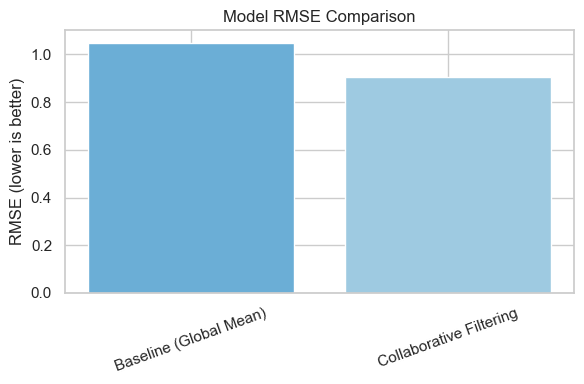

✅ Evaluation complete and plotted


In [22]:

results = pd.DataFrame({
    'Model': ['Baseline (Global Mean)', 'Collaborative Filtering'],
    'RMSE': [baseline_rmse, cf_rmse]
})

display(results)


import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(results['Model'], results['RMSE'], color=['#6baed6', '#9ecae1'])
ax.set_title('Model RMSE Comparison')
ax.set_ylabel('RMSE (lower is better)')
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

print("✅ Evaluation complete and plotted")
